In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

In [2]:
#Putting cols in lowercase and replace spaces
def df_col_clnr(df):
    for i in df.columns:
        txt = re.sub(" ","_",i)
        txt = txt.lower()
        if txt == "booking_class_of_service":
            txt = "cos"
        df = df.rename(columns={i : txt})
        #print(txt)
    return df
df = pd.read_excel(os.path.join("alaska","Assessment_RM.xlsx"))
df = df_col_clnr(df)
df["cos_cnt"]=[1 for i in range(len(df))]

In [3]:
##SHOWS lin correlation between tickets sold and revenue earned (linear correlation)
total_tx_df = pd.DataFrame({"flight_date":df["flight_date"], "total_tc_cnt":df["cos_cnt"]})
total_tx_df = total_tx_df.groupby(total_tx_df["flight_date"]).sum()
total_tx_df = total_tx_df.reset_index(drop=False)

total_rev_df = pd.DataFrame({"flight_date":df["flight_date"],
                       "total_rev":df.fare_amount})
total_rev_df = total_rev_df.groupby(total_rev_df["flight_date"]).sum()
total_rev_df = total_rev_df.reset_index(drop=False)

merged_total_rev_df = pd.merge(total_tx_df, total_rev_df, on='flight_date')

In [4]:
##SHOWS lin correlation between total_rev and by cos total rev
total_rev_df = pd.DataFrame({"flight_date":df["flight_date"],
                       "total_rev":df.fare_amount})
total_rev_df = total_rev_df.groupby(total_rev_df["flight_date"]).sum()
total_rev_df = total_rev_df.reset_index(drop=False)

cos_rev_sum = pd.DataFrame({"flight_date":df.flight_date,
                       "cos":df.cos,
                       "cos_rev_sum":df.fare_amount
                      })

cos_rev_sum = cos_rev_sum.groupby(["flight_date","cos"]).sum()
cos_rev_sum = cos_rev_sum.reset_index(drop=False)

merged_tr_cr_df = pd.merge(total_rev_df, cos_rev_sum, on='flight_date')

In [5]:
##SHOWS lin correlation between cos_cnt and sum by cos earned
cos_cnt = pd.DataFrame({"flight_date":df.flight_date,
                       "cos":df.cos,
                       "cos_cnt":df.cos_cnt
                      })

cos_cnt = cos_cnt.groupby(["flight_date","cos"]).sum()

cos_cnt = cos_cnt.reset_index(drop=False)

merged_cos_sub_df = pd.merge(cos_cnt, cos_rev_sum, on=['flight_date','cos'])

In [6]:
#Used to gen model by booking cos
def model_gen(df_in,goal,filt):
#INPUTS:
    #df_in: dataframe w/merged revenue data according to goal
    #goal:predicting total revenue, total booking cos rev, count of booking cos
    #filt: used in cos_rev/cos_cnt to analyze by booking cos
#OUTPUT: Posterior of bayes linear model
     
    if goal == "total_rev":
        data = pd.DataFrame({'total_number':df_in.total_tc_cnt,
                             'total_rev':df_in.total_rev})
    if goal == "cos_rev":
        df_in = df_in[df_in['cos'] == filt]
        data = pd.DataFrame({'total_number':[i for i in df_in.total_rev],
                             'total_rev':[i for i in df_in.cos_rev_sum]}) 
    if goal == "cos_cnt":
        df_in = df_in[df_in['cos'] == filt]
        data = pd.DataFrame({'total_number':[i for i in df_in.cos_rev_sum],
                             'total_rev':[i for i in df_in.cos_cnt]})
        
    # Bayesian Linear Regression Model
    with pm.Model() as model:
        # Priors for parameters
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=5)
 
    
        # Linear model
        mu = alpha + beta * data['total_number']
    
        # Likelihood
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data['total_rev'])
    
        # Inference
        trace = pm.sample(2000, tune=1000)

    return trace

In [7]:
trace_1 = model_gen(merged_total_rev_df,"total_rev",None)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]


/home/bparry21/alaska/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
# Predictive model for new data
def predict_revenue(total_number, trace):
#INPUTS:
    #total_number: dependent
    #trace: posterior
#OUTPUTS:
    #mean_prediction
    #credible_interval
    alpha_samples = trace['posterior']['alpha'].values.flatten()
    beta_samples = trace['posterior']['beta'].values.flatten()
    
    # Calculate predicted revenue for each sample from the posterior
    predicted_revenue_samples = alpha_samples + beta_samples * total_number
    
    # Return the mean and 95% credible interval of the predictions
    mean_prediction = np.mean(predicted_revenue_samples)
    credible_interval = np.percentile(predicted_revenue_samples, [2.5, 97.5])
    
    return mean_prediction, credible_interval

In [10]:
###PLOT WORK IN PROG
def plot_predict(df_in, filt,goal,total_rev_mean,cos_predicted_mean,cos_credible_interval,title):
#INPUT VARS:
    #total_rev_mean
    #cos_predicted_mean
    #cos_predicted_interval
#OUTPUT:
    #scatter plot w/ prediction from posterior
    if goal == "total_rev":
        data = pd.DataFrame({'total_number':df_in.total_tc_cnt,
                             'total_rev':df_in.total_rev})
    if goal == "cos_rev":
        df_in = df_in[df_in['cos'] == filt]
        data = pd.DataFrame({'total_number':[i for i in df_in.total_rev],
                             'total_rev':[i for i in df_in.cos_rev_sum]}) 
    if goal == "cos_cnt":
        df_in = df_in[df_in['cos'] == filt]
        data = pd.DataFrame({'total_number':[i for i in df_in.cos_rev_sum],
                             'total_rev':[i for i in df_in.cos_cnt]})
    print(f"Predicted revenue for total number {total_rev_mean}: {cos_predicted_mean:.2f}")
    print(f"95% Credible Interval: [{cos_credible_interval[0]:.2f}, {cos_credible_interval[1]:.2f}]")
    
    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.scatter(data['total_number'], data['total_rev'], label='Observed Data')
    
    # Plot posterior predictive lines
    total_number_range = np.linspace(data['total_number'].min(), data['total_number'].max(), 200)
    #for i in np.random.randint(0, len(trace['posterior']['alpha']), 200):
    #    plt.plot(total_number_range, trace['posterior']['alpha'][0][i] + trace['posterior']['beta'][0][i] * total_number_range, color='gray', alpha=0.1)
    
    #plt.plot(total_number_range, np.mean(trace['posterior']['alpha']) + np.mean(trace['posterior']['beta']) * total_number_range, color='red', label='Mean Prediction')
    plt.axvline(x=total_rev_mean, color='green', linestyle='--', label=f'New Total Number ({total_rev_mean})')
    plt.scatter(total_rev_mean, cos_predicted_mean, color='blue', marker='x', s=100, label=f'Predicted Revenue ({cos_predicted_mean:.2f})')
    plt.fill_between([total_rev_mean, total_rev_mean], cos_credible_interval[0], cos_credible_interval[1], color='blue', alpha=0.2, label='95% Credible Interval')
    
    plt.xlabel('Total Number')
    plt.ylabel('Revenue')
    plt.title('Bayesian Linear Regression: Revenue Prediction')
    plt.legend()
    plt.grid(True)
    plt.savefig("{}.jpg".format(title))
    plt.show()

In [9]:
# Example prediction for a total number of 275
new_total_number = 260
predicted_mean, credible_interval = predict_revenue(new_total_number, trace_1)

Predicted revenue for total number 260: 127536.70
95% Credible Interval: [127233.79, 127846.34]


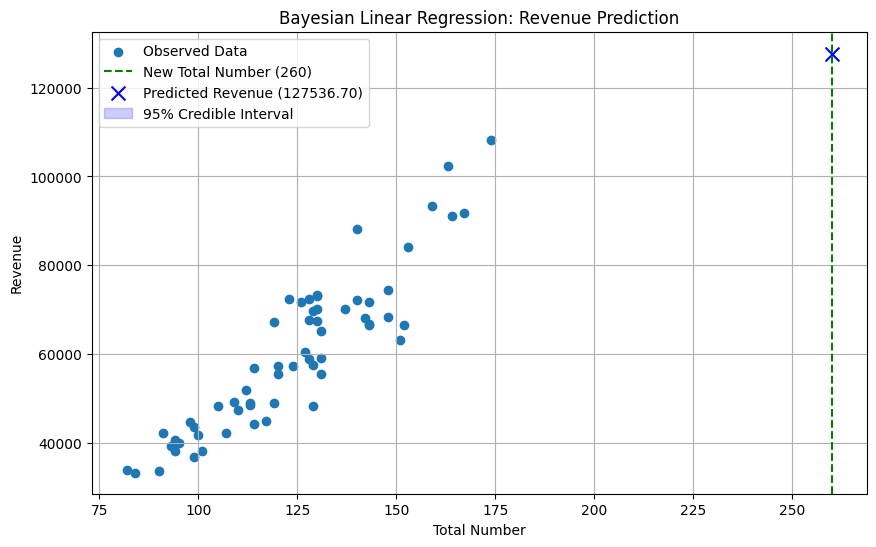

In [11]:
plot_predict(merged_total_rev_df, None,"total_rev",new_total_number,predicted_mean,credible_interval,"total_rev_posterior")

In [12]:
#Passing this var to make filtering easier for subsequent predictions
cos_var = "N"

In [13]:
trace_2 = model_gen(merged_tr_cr_df,"cos_rev",cos_var)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]


/home/bparry21/alaska/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [14]:
#Using lower bound given mean exceeds 260 ceilling at 306 seats
# total_rev_mean = predicted_mean
total_rev_mean = credible_interval[0]
cos_predicted_mean, cos_credible_interval = predict_revenue(total_rev_mean, trace_2)

Predicted revenue for total number 127233.78557855368: 18074.66
95% Credible Interval: [17769.47, 18374.29]


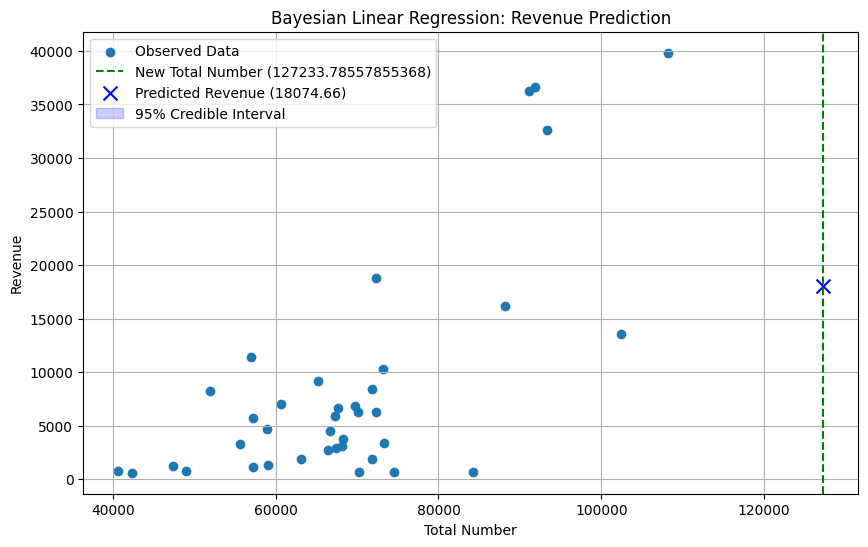

In [15]:
plot_predict(merged_tr_cr_df, cos_var,"cos_rev",total_rev_mean,cos_predicted_mean,cos_credible_interval,"cos_rev_posterior")

In [16]:
trace_3 = model_gen(merged_cos_sub_df,"cos_cnt",cos_var)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]


/home/bparry21/alaska/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
#Using lower bound given mean exceeds 260 ceilling at 306 seats
cos_total_rev_mean = cos_credible_interval[0]
cos_cnt_predicted_mean, cos_cnt_credible_interval = predict_revenue(cos_total_rev_mean, trace_3)

Predicted revenue for total number 17769.468855613057: 27.94
95% Credible Interval: [27.78, 28.10]


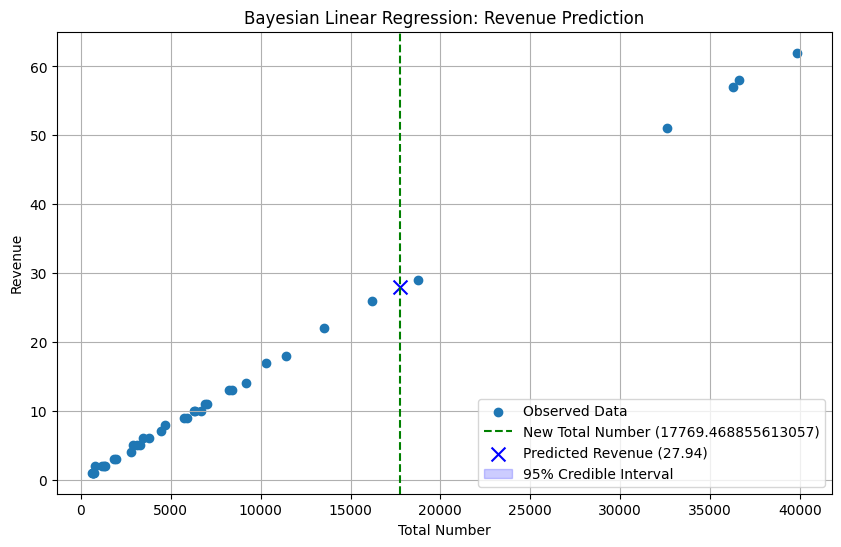

In [18]:
plot_predict(merged_cos_sub_df, cos_var,"cos_cnt",cos_total_rev_mean,cos_cnt_predicted_mean,cos_cnt_credible_interval,
             "cos_cnt_posterior")


In [ ]:
avg_tc_cost = cos_predicted_mean/cos_cnt_credible_interval[0]

In [ ]:
#Generated outputs iter to conserve memory/processing
df_out = pd.DataFrame({"CoS":[cos_var],"avg_tct_cost":[avg_tc_cost],
                         "cos_cnt":[cos_cnt_credible_interval[0]]})


In [ ]:
#appending to out_df
def append_forecast(df_in):
    forecast = pd.read_excel("alaska_forecast_lower.xlsx")
    forecast.drop(columns=["Unnamed: 0"], inplace =True)
    df_combined = pd.merge(forecast, df_in, on=list(forecast.columns),
                          how="outer")
    #df_combined.drop(columns=["Unnamed: 0"], inplace=True)
    return df_combined

In [ ]:
out_combined = append_forecast(df_out)

In [ ]:
#out_combined.head(20)

In [ ]:
#LOWER BOUND results in a forecast overbooking by .099

In [ ]:
#what data should I need and what to do to get that
#over sell by 40, why is variance that large? it's greater than 2 sd
#why is that the closest you can get?
#Time needs to be factored for overselling, this is what we are getting
# considering this factor and this we will get optimal price given X seats, there can be more percission by adding time
#I would like to test these prices before adding in the 3rd layer
# more percision if you add in timing of forecasted pricing and fine tune seasonality 
#I am trying to achieve getting to a data set of getting to a full flight then I can get to the next phase,
#now I can layer in other variables such as booking windows and seasonality in order to further optimize the model

In [ ]:
##TODO: get last years avg revenue per flight for comparison
#TODO:
#write output dataframe recording avg_cost of seat, total cos seats to sell, overall revenue of flight
#avg revenue from last years data

In [ ]:
###CONTROLS TO PREVENT OVERBOOKING
#I am recommending a price reduction because the flight is underbooked. 
#I am able to predict the booking CoS count of a full flight using a bayesian generalized linear model to predict
#total revenue given the tickets purchased, total booking CoS revenue given the total flight revenue,
#and the total booking CoS seats sold given the forecasted booking CoS total revenue sold.
#Using this methodology I can maximize revenue for the Alaska Airlines flight by filling all vacant seats
#while still increasing the overall revenue of each flight sold.
#While this model will help in maximizing revenue, I would also recommend limiting the price reductions to the
#forecasted booking CoS seat count in order to prevent overbooking the flight
#By using the lower bound of the linear model I will achieve a higher level percision given that the mean and upper 
#bound of the linear regression line surpasses the 260 seat ceilling.

#GOAL: is to try succeeding at one variable at a time. I am attempting to maximize revenue by increasing
# the total tickets booked. After proving, that the cost modifications increases revenue to the projected total,
# I would then like to model seasonality and it's effect on booking CoS prices while keeping flights full
# I would then like to model the rate of purchases of booking CoS as a methodology to control ticket pricing
# I want to maximize the total amount of tickets sold while preventing overbooking. I do not know the impact of a price
# decrease and want to test the linear model projections before adding in additional variables. 

#Booking CoS forecast purchases per month could be used to help prevent overbooking
#The approach that i would like to do is to understand the variables of maximizing revenue independently
# before combining them
#Max seats, price for booking window, step 3 dynamic pricing for multiple variables
#drawbacks: speed
# Problem, we have not sold a full flight, in order to make these predictions, maximizing seats in order to
# add a full flight to our prior will help in making predictions in seasonality and dynamic pricing models
# Testing this model in reality will help prevent overbooking and enable increased accuracy when looking at
# maximizing revenue according to seasonality (time)
#IF THIS MODEL WORKS then I can change the factor of time in order to further maximize revenue
# this would help in instances where people may be willing to purchase a given CoS at a higher price than currently
#forecasted. However, it is important to note that these instances are outliers and would require further anlaysis
# to prove they are dependent on time. One instance would be the N booking CoS where spikes in tickets sold
# did not occur on what would normally appear to be holiday traffic

#Additional work to enhance the effectiveness of this model
#Pricing window will likely enhance the effectiveness of a price reduction while also help prevent overbooking
#Fine tuning Seasonality analysis will likely result in identifying instances where a price increase is warranted 
#and further maximize overall flight revenue


In [ ]:
###END Scratch follows

In [ ]:
#Manual col additions to output to show 3.8 million forecasted rev diff when compared to last years max rev flight
# out_combined = pd.read_excel("alaska_forecast_lower.xlsx")
# out_combined["forecasted_rev"] = [float(credible_interval[0]) for i in range(len(out_combined))]
# out_combined["max_hist_rev"] = [total_rev_df.total_rev.max() for i in range(len(out_combined))]
# out_combined["rev_diff"] = out_combined["forecasted_rev"] - out_combined["max_hist_rev"]
# out_combined["forecasted_wkly_diff"] = out_combined["rev_diff"]*4
# out_combined["forecasted_yrly_diff"] = out_combined["forecasted_wkly_diff"]*52
# out_combined.drop(columns=["Unnamed: 0"],inplace = True)
# out_combined.to_excel("alaska_forecast_lower.xlsx")
